# 6. Deep Learning Models

* We'll build DL models on the raw time-series data and compare the performance to our traditional ML models.

In [127]:
import numpy as np
import pandas as pd
from dl_utils import plot_metrics, plot_confusion_matrix
np.random.seed(42)

from IPython.display import display

# Importing libraries
from keras.models import Model, Sequential
from keras.layers import LSTM, GRU, BatchNormalization
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

__LIST OF FETAURES and ACTIVITIES__

In [2]:
SIGNALS = ["body_acc_x",
           "body_acc_y",
           "body_acc_z",
           "body_gyro_x",
           "body_gyro_y",
           "body_gyro_z",
           "total_acc_x",
           "total_acc_y",
           "total_acc_z"]

ACTIVITIES = {1 : 'WALKING',
              2 : 'WALKING_UPSTAIRS',
              3 : 'WALKING_DOWNSTAIRS',
              4 : 'SITTING',
              5 : 'STANDING',
              6 : 'LAYING'}

## 6.1 Loading the data

* Here we load the raw time-series data in which each datapoint has 128 readings each for 9 different signals.

In [3]:
# Utility function to read the data from csv file
def read_txt(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_data(subset, signals=SIGNALS):
    signals_data = []
    
    #signal_data
    for s in signals:
        #print(s)
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{s}_{subset}.txt'
        signals_data.append(read_txt(filename).values)
        
    #label_data
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = read_txt(filename)[0]
    
    #reshape the signals_data into (#samples, 128readings along time, 9featueres)
    return np.transpose(signals_data, axes=(1, 2, 0)), pd.get_dummies(y).values

In [4]:
Xtrain, Ytrain = load_data('train')
Xtest, Ytest = load_data('test')

print(f"Shape of Xtrain : {Xtrain.shape}")
print(f"Shape of Xtest  : {Xtest.shape}")

Shape of Xtrain : (7352, 128, 9)
Shape of Xtest  : (2947, 128, 9)


In [5]:
print(f"Number of data_points in Xtrain               : {Xtrain.shape[0]}")
print(f"Number of data_points in Xtest                : {Xtest.shape[0]}")

print(f"Number of features/signals                    : {Xtrain.shape[-1]}")
print(f"Number of readings along time per each signal : {Xtrain.shape[1]}")

Number of data_points in Xtrain               : 7352
Number of data_points in Xtest                : 2947
Number of features/signals                    : 9
Number of readings along time per each signal : 128


In [131]:
def metrics(Xtrain, Ytrain, Xtest, Ytest, model):
    
    train = model.evaluate(Xtrain, Ytrain, verbose=0)
    test = model.evaluate(Xtest, Ytest, verbose=0)
    
    display(pd.DataFrame([train, test], columns=['LOG_LOSS', 'ACCURACY'], index=['TRAIN', 'TEST']))
    
    return train + test

In [139]:
models_eval_dict = {'columns' : ['TRAIN_LOG_LOSS', 'TRAIN_ACC', "TEST_LOG_LOSS", "TEST_ACC"]}

## 6.1 Neural Net

* We'll use a __simple neural net with two hidden layers__ to train the model.
* The input will be the flattened 128 vectors of 9 signals stripping the time dependency.

In [146]:
Xtrain_reshaped = Xtrain.reshape(Xtrain.shape[0], -1)
Xtest_reshaped = Xtest.reshape(Xtest.shape[0], -1)

print(f"Shape of Xtrain_reshaped : {Xtrain_reshaped.shape}")
print(f"Shape of Xtest_reshaped  : {Xtest_reshaped.shape}")

Shape of Xtrain_reshaped : (7352, 1152)
Shape of Xtest_reshaped  : (2947, 1152)


In [199]:
model1 = Sequential()
model1.add(Dense(128, activation='relu', kernel_initializer='he_normal', 
                 input_shape=(Xtrain.reshape(Xtrain.shape[0], -1).shape[1:])))
model1.add(Dropout(0.25))
model1.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model1.add(Dropout(0.25))
model1.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model1.add(Dropout(0.25))
model1.add(Dense(Ytrain.shape[1], activation='softmax'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 128)               147584    
_________________________________________________________________
dropout_62 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_63 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_64 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 6)                 198       
Total para

In [200]:
# Compiling the model
model1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#checkpoint the best model based on log_loss
filepath = 'saved_models/dnn_best_weights2.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)
callbacks_list = [checkpoint]

In [201]:
# Training the model
model1.fit(Xtrain_reshaped,
           Ytrain,
           batch_size=512,
           validation_data=(Xtest_reshaped, Ytest),
           epochs=75, 
           shuffle=True,
           callbacks=callbacks_list)

Train on 7352 samples, validate on 2947 samples
Epoch 1/75
7352/7352 [==============================] - 3s 365us/step - loss: 1.3480 - acc: 0.4625 - val_loss: 0.9894 - val_acc: 0.6654
Epoch 2/75
7352/7352 [==============================] - 0s 31us/step - loss: 0.9953 - acc: 0.6317 - val_loss: 0.7950 - val_acc: 0.7961
Epoch 3/75
7352/7352 [==============================] - 0s 27us/step - loss: 0.8145 - acc: 0.7084 - val_loss: 0.6819 - val_acc: 0.7913
Epoch 4/75
7352/7352 [==============================] - 0s 26us/step - loss: 0.6763 - acc: 0.7643 - val_loss: 0.5743 - val_acc: 0.8381
Epoch 5/75
7352/7352 [==============================] - 0s 26us/step - loss: 0.5872 - acc: 0.8003 - val_loss: 0.5273 - val_acc: 0.8507
Epoch 6/75
7352/7352 [==============================] - 0s 29us/step - loss: 0.4890 - acc: 0.8380 - val_loss: 0.4475 - val_acc: 0.8541
Epoch 7/75
7352/7352 [==============================] - 0s 31us/step - loss: 0.4363 - acc: 0.8515 - val_loss: 0.4314 - val_acc: 0.8554
Epoch 

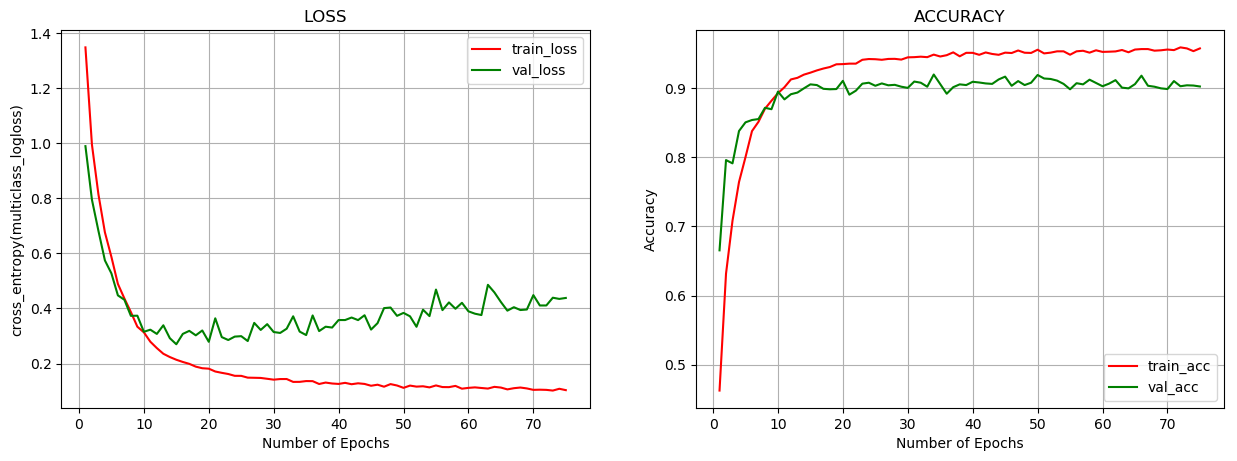

In [202]:
plot_metrics(model1.history)

In [203]:
model1.load_weights(filepath)

In [204]:
models_eval_dict['DNN'] = metrics(Xtrain_reshaped, Ytrain, Xtest_reshaped, Ytest, model1)

,LOG_LOSS,ACCURACY
TRAIN,0.112681,0.954570
TEST,0.269883,0.905667


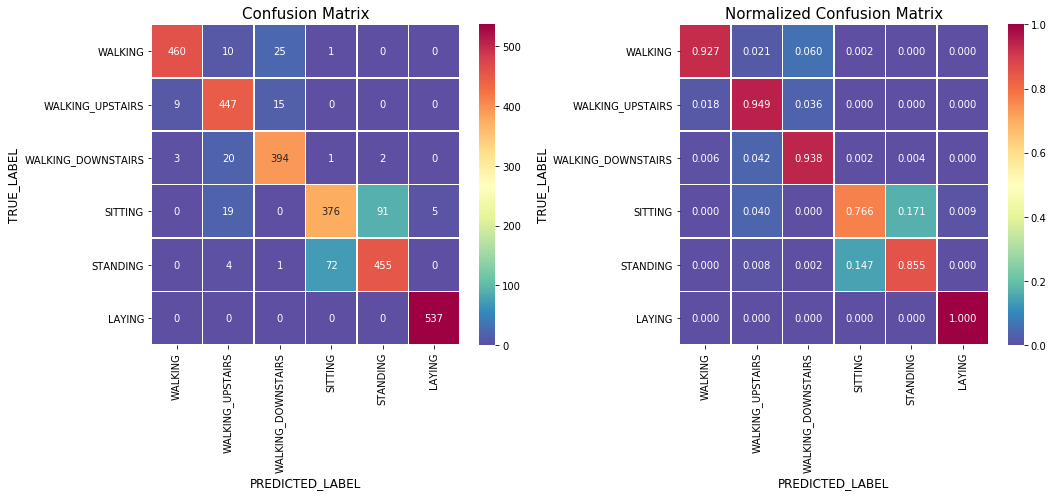

In [205]:
plot_confusion_matrix(Ytest.argmax(1), model1.predict(Xtest_reshaped).argmax(1), labels=ACTIVITIES.values())

__<font color='green'> OBSERVATIONS</font>__

* A simple neural net achieved good performance ~90% accuracy.
* The confusion matrix shows that the same issue exists as before <br>
with the classifier having a hard time to seperate STANDING and SITTING classes.
* The precision and recall values of classes : SITTING and STANDING are worse.
* The log loss(0.26) is significantly greater than the linear model's one(0.16).

## 6.2 LSTM

* We'll build an RNN with two LSTM layers stacked upon one other.

In [165]:
# Initiliazing the sequential model
model2 = Sequential()
# Configuring the parameters
model2.add(LSTM(96, input_shape=(Xtrain.shape[1:]), return_sequences=True))
# Adding a dropout layer
model2.add(Dropout(0.25))

model2.add(LSTM(64))
# Adding a dropout layer
model2.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model2.add(Dense(Ytrain.shape[1], activation='softmax'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128, 96)           40704     
_________________________________________________________________
dropout_45 (Dropout)         (None, 128, 96)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                41216     
_________________________________________________________________
dropout_46 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 6)                 390       
Total params: 82,310
Trainable params: 82,310
Non-trainable params: 0
_________________________________________________________________


In [166]:
#sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

# Compiling the model
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

filepath = 'saved_models/lstm_best_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)
callbacks_list = [checkpoint]

In [167]:
# Training the model
model2.fit(Xtrain,
          Ytrain,
          batch_size=1024,
          validation_data=(Xtest, Ytest),
          epochs=100,
          shuffle=True,
          callbacks=callbacks_list)

Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 13s 2ms/step - loss: 1.7519 - acc: 0.2739 - val_loss: 1.6506 - val_acc: 0.3573
Epoch 2/100
7352/7352 [==============================] - 10s 1ms/step - loss: 1.5361 - acc: 0.3868 - val_loss: 1.3791 - val_acc: 0.3658
Epoch 3/100
7352/7352 [==============================] - 10s 1ms/step - loss: 1.3900 - acc: 0.3924 - val_loss: 1.3055 - val_acc: 0.4554
Epoch 4/100
7352/7352 [==============================] - 10s 1ms/step - loss: 1.2561 - acc: 0.4644 - val_loss: 1.1860 - val_acc: 0.5131
Epoch 5/100
7352/7352 [==============================] - 10s 1ms/step - loss: 1.1594 - acc: 0.4933 - val_loss: 1.1647 - val_acc: 0.5256
Epoch 6/100
7352/7352 [==============================] - 10s 1ms/step - loss: 1.1359 - acc: 0.5107 - val_loss: 1.1198 - val_acc: 0.5154
Epoch 7/100
7352/7352 [==============================] - 10s 1ms/step - loss: 1.0950 - acc: 0.5442 - val_loss: 1.0826 - val_acc: 0.5819


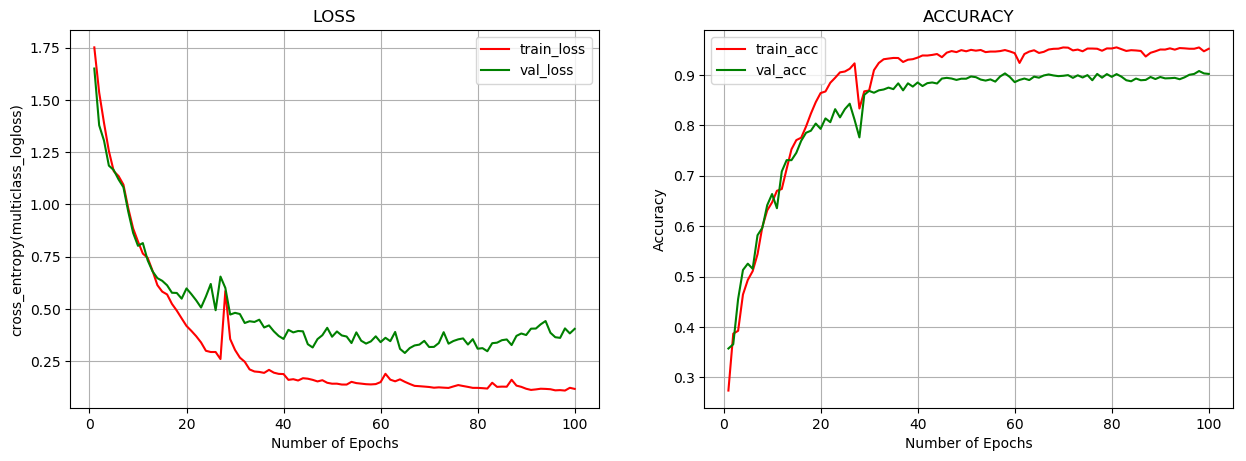

In [206]:
plot_metrics(model2.history)

In [171]:
filepath = 'saved_models/lstm_best_weights.hdf5'
model2.load_weights(filepath)

In [172]:
models_eval_dict['LSTM'] = metrics(Xtrain, Ytrain, Xtest, Ytest, model2)

,LOG_LOSS,ACCURACY
TRAIN,0.148843,0.937704
TEST,0.257092,0.898541


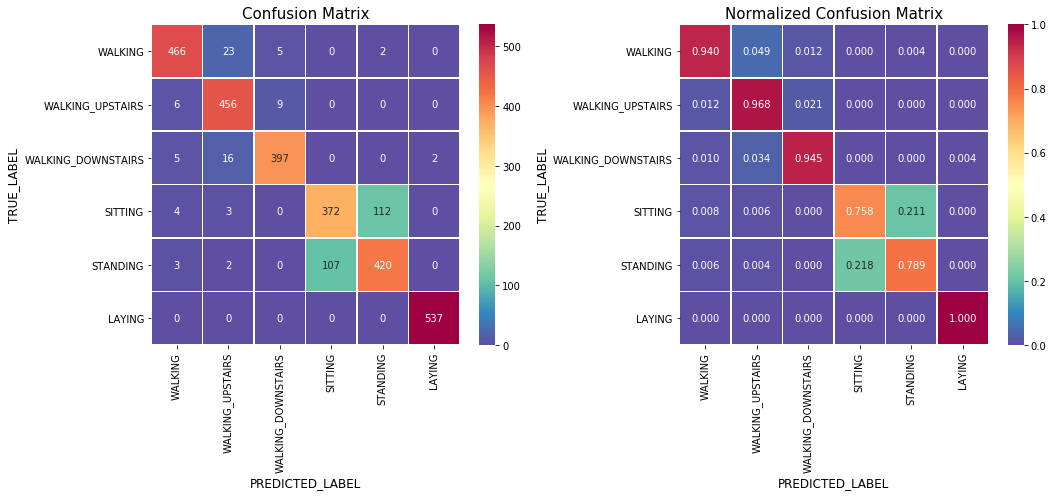

In [173]:
plot_confusion_matrix(Ytest.argmax(1), model2.predict(Xtest).argmax(1), labels=ACTIVITIES.values())

__<font color='green'> OBSERVATIONS</font>__

* Training a complex network like RNN requires huge computational resources and data.
* The same issue exists here. The performance is worser than the linear models.

## 6.3 Models Summary

In [175]:
if 'columns' in models_eval_dict:
    columns = models_eval_dict.pop('columns')
    
display(pd.DataFrame.from_dict(models_eval_dict, orient='index', columns=columns))

,TRAIN_LOG_LOSS,TRAIN_ACC,TEST_LOG_LOSS,TEST_ACC
DNN,0.099205,0.954706,0.299371,0.900238
LSTM,0.148843,0.937704,0.257092,0.898541


## 6.4 Conclusion

* Both the deep neural nets (DNN and RNN) failed to overcome the limitations of the linear models.
* __It is to be noted that the models were trained on the raw time-series data__.
* Even a simple 1 layer neural net tends to perform on par with these models.
* Both the models showed signs of overfitting.
* After much  hyper-parameter tuning, it was found out that __we are beating a dead horse__ 
<br> and the performance never seemed to improve.